In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [3]:
data=pd.read_csv('ecg.csv',header=None)
data.head()

FileNotFoundError: [Errno 2] No such file or directory: 'ecg.csv'

In [13]:
data.shape

NameError: name 'x_train' is not defined

In [24]:
#splitting training and testing dataset
features = data.drop(140, axis=1)
target = data[140]
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2)
train_index = y_train[y_train == 1].index
train_data = x_train.loc[train_index]


In [28]:
#MinMaxScaling 
min_max_scaler=MinMaxScaler(feature_range=(0,1))
x_train_scaled=min_max_scaler.fit_transform(train_data.copy())
x_test_scaled=min_max_scaler.transform(x_test.copy())


In [30]:
# Creating Autoencoder subclass by extending Model class from keras.
class AutoEncoder(Model):
    def __init__(self,output_units,ldim=8):
        super().__init__()
        self.encoder=Sequential([
            Dense(64,activation='relu'),
            Dropout(0.1),
            Dense(32,activation='relu'),
            Dropout(0.1),
            Dense(16,activation='relu'),
            Dropout(0.1),
            Dense(ldim,activation='relu')
        ])
        
        self.decoder=Sequential([
            Dense(16,activation='relu'),
            Dropout(0.1),
            Dense(32,activation='relu'),
            Dropout(0.1),
            Dense(64,activation='relu'),
            Dropout(0.1),
            Dense(output_units,activation='sigmoid')
        ])
        
    def call(self,inputs):
        encoded=self.encoder(inputs)
        decoded=self.decoder(encoded)
        return decoded


In [32]:
x_train_scaled.shape


(2328, 140)

In [35]:
model=AutoEncoder(output_units=x_train_scaled.shape[1])
model.compile(optimizer="adam",loss="msle",metrics=['mse'])
history=model.fit(x_train_scaled,x_train_scaled,epochs=20,batch_size=512,validation_data=(x_test_scaled,x_test_scaled))

Epoch 1/20
5/5 [==============================] - 3s 85ms/step - loss: 0.0109 - mse: 0.0247 - val_loss: 0.0132 - val_mse: 0.0305
Epoch 2/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0107 - mse: 0.0241 - val_loss: 0.0130 - val_mse: 0.0301
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0102 - mse: 0.0230 - val_loss: 0.0127 - val_mse: 0.0293
Epoch 4/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0092 - mse: 0.0208 - val_loss: 0.0125 - val_mse: 0.0288
Epoch 5/20
5/5 [==============================] - 0s 28ms/step - loss: 0.0083 - mse: 0.0186 - val_loss: 0.0122 - val_mse: 0.0281
Epoch 6/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0073 - mse: 0.0163 - val_loss: 0.0116 - val_mse: 0.0267
Epoch 7/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0065 - mse: 0.0146 - val_loss: 0.0114 - val_mse: 0.0263
Epoch 8/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0059 - mse: 0.0133 - val

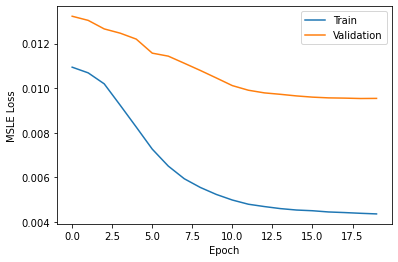

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epoch")
plt.ylabel("MSLE Loss")
plt.legend(['Train','Validation'])
plt.show()

In [50]:
def find_threshold(model,x_train_scaled):
    reconstructions=model.predict(x_train_scaled)
    reconstruction_error=tf.keras.losses.msle(reconstructions,x_train_scaled)
    threshold=np.mean(reconstruction_error.numpy()) + np.std(reconstruction_error.numpy())
    return threshold
def get_predictions(model,x_test_scaled,threshold):
    reconstructions=model.predict(x_test_scaled)
    errors=tf.keras.losses.msle(reconstructions,x_test_scaled)
    anamoly_mask=pd.Series(errors)>threshold
    preds=anamoly_mask.map(lambda x:0.0 if x==True else 1.0)
    return preds

In [51]:
threshold=find_threshold(model,x_train_scaled)
threshold

73/73 [==============================] - 0s 3ms/step


0.009611682503561664

In [52]:
predictions=get_predictions(model,x_test_scaled,threshold)
accuracy_score(predictions,y_test)

32/32 [==============================] - 0s 3ms/step


0.932